In [1]:
import sys

sys.path.insert(0, "../")
import regridcart as rc

import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
target_domain = rc.LocalCartesianDomain(
    central_latitude=14.0,
    central_longitude=-48,
    l_meridional=1000.0e3,
    l_zonal=3000.0e3,
)

<IPython.core.display.Javascript object>

In [4]:
target_domain.latlon_bounds

array([[-62.2055359 ,  18.08410886,   0.        ],
       [-33.7944641 ,  18.08410886,   0.        ],
       [-34.32928943,   9.12139872,   0.        ],
       [-61.67071057,   9.12139872,   0.        ]])

<IPython.core.display.Javascript object>

<GeoAxesSubplot:>

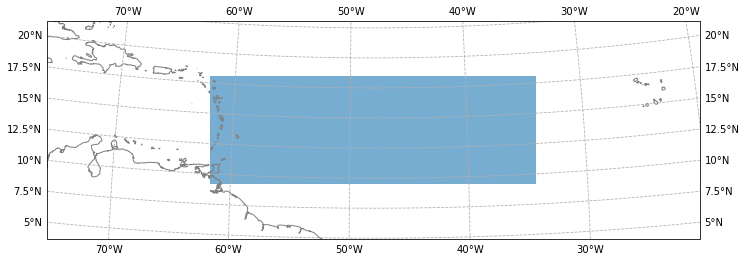

<IPython.core.display.Javascript object>

In [5]:
target_domain.plot_outline()

# Data on grid aligned with lat/lon coordinates

In [6]:
"""
Test cropping and resampling of data with x- and y-coordinates given by
longitude and latitude values respecively (i.e. the underlying grid
coordinates follow the latitude and longitude directions)
"""

# TODO: add test to ensure the resampling values are correct instead of
# just ensuring that no exceptions are raised
dlat, dlon = 0.1, 0.1
lat_span = [5.0, 20.0]
lon_span = [-70.0, -30.0]
extent = lon_span + lat_span  # for plotting later

lat0 = 0.5 * (lat_span[0] + lat_span[1])
lon0 = 0.5 * (lon_span[0] + lon_span[1])

lats = np.arange(*lat_span, dlat)
lons = np.arange(*lon_span, dlon)

ds = xr.Dataset(coords=dict(lat=lats, lon=lons))

# make a field to interpolate
ds["phi"] = np.sin(ds.lat) * np.cos(ds.lon)
ds.phi

<xarray.DataArray 'phi' (lat: 150, lon: 400)>
array([[-0.60730516, -0.6783578 , -0.74263251, ..., -0.42129892,
        -0.33319576, -0.24176342],
       [-0.58633622, -0.65493556, -0.716991  , ..., -0.40675237,
        -0.32169123, -0.23341585],
       [-0.5595088 , -0.62496943, -0.68418556, ..., -0.38814169,
        -0.30697246, -0.22273606],
       ...,
       [ 0.47598588,  0.53167461,  0.58205102, ...,  0.33020028,
         0.26114792,  0.18948624],
       [ 0.5153152 ,  0.57560533,  0.6301442 , ...,  0.35748377,
         0.28272581,  0.20514294],
       [ 0.54949567,  0.61378479,  0.67194118, ...,  0.3811954 ,
         0.3014788 ,  0.21874992]])
Coordinates:
  * lat      (lat) float64 5.0 5.1 5.2 5.3 5.4 5.5 ... 19.5 19.6 19.7 19.8 19.9
  * lon      (lon) float64 -70.0 -69.9 -69.8 -69.7 ... -30.4 -30.3 -30.2 -30.1

<IPython.core.display.Javascript object>

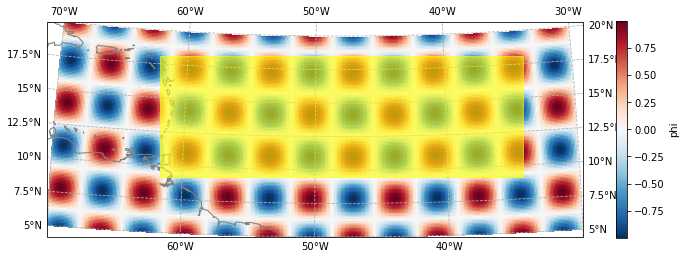

<IPython.core.display.Javascript object>

In [7]:
ax = target_domain.plot_outline(color="yellow", zorder=10)
ds.phi.plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

/Volumes/agile/tooling/miniconda3/envs/regridcart/lib/python3.7/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


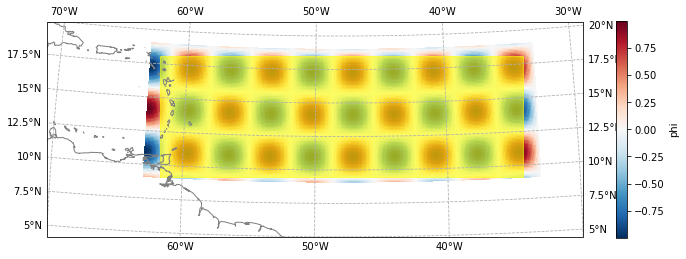

<IPython.core.display.Javascript object>

In [8]:
da_phi = ds.phi
da_phi_cropped = rc.crop_field_to_domain(domain=target_domain, da=da_phi, pad_pct=0.0)

ax = target_domain.plot_outline(color="yellow")
da_phi_cropped.plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

In [9]:
dx = 50.0e3  # [m]
da_phi_resampled = rc.resample(target_domain, da=da_phi_cropped, dx=dx)
da_phi_resampled

/Volumes/agile/tooling/miniconda3/envs/regridcart/lib/python3.7/site-packages/xesmf/smm.py:129: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


<xarray.DataArray (y: 20, x: 60)>
array([[ 0.01268515, -0.01155299, -0.01429116, ..., -0.01333286,
        -0.03955194, -0.06687458],
       [-0.07783706,  0.09627814,  0.26811794, ...,  0.26158693,
         0.35789337,  0.37190235],
       [-0.16901191,  0.16956485,  0.48631523, ...,  0.49690607,
         0.69056567,  0.73620671],
       ...,
       [-0.55828176, -0.14722886,  0.30234101, ...,  0.84947335,
         0.9617872 ,  0.86155598],
       [-0.60335961, -0.18052249,  0.27742118, ...,  0.87230403,
         0.98219749,  0.87762891],
       [-0.52603182, -0.1744809 ,  0.20182053, ...,  0.71965457,
         0.81044468,  0.72116775]])
Coordinates:
    lon      (y, x) float64 -61.45 -60.99 -60.54 -60.08 ... -35.0 -34.52 -34.05
    lat      (y, x) float64 9.358 9.381 9.403 9.425 ... 17.96 17.93 17.9 17.87
  * x        (x) float64 -1.475e+06 -1.425e+06 ... 1.425e+06 1.475e+06
  * y        (y) float64 -4.75e+05 -4.25e+05 -3.75e+05 ... 4.25e+05 4.75e+05
Attributes:
    regrid_method:  bilinear

<IPython.core.display.Javascript object>

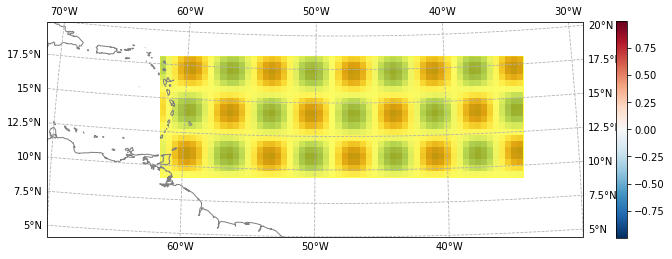

<IPython.core.display.Javascript object>

In [10]:
ax = target_domain.plot_outline(color="yellow")
da_phi_resampled.plot(ax=ax, transform=target_domain.crs)
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Data on grid with lat/lon given as auxilliary variables

In [14]:
# generate some sample data on a regular lat/lon grid
ds = xr.Dataset(
    coords=dict(x=np.arange(-20.0, 20.0, 0.5), y=np.arange(-10.0, 10.0, 0.5))
)

# the lat/lon coords will be simply given as rotations here
theta = 20.0 * 3.14 / 180.0
ds.coords["lon"] = np.cos(theta) * ds.x - np.sin(theta) * ds.y - 50.0
ds.coords["lat"] = np.sin(theta) * ds.x + np.cos(theta) * ds.y + lat0

ds["phi"] = np.cos(ds.x / 4.0) * np.sin(ds.y)
ds

<xarray.Dataset>
Dimensions:  (x: 80, y: 40)
Coordinates:
  * x        (x) float64 -20.0 -19.5 -19.0 -18.5 -18.0 ... 18.0 18.5 19.0 19.5
  * y        (y) float64 -10.0 -9.5 -9.0 -8.5 -8.0 -7.5 ... 7.5 8.0 8.5 9.0 9.5
    lon      (x, y) float64 -65.38 -65.55 -65.72 -65.89 ... -34.58 -34.75 -34.92
    lat      (x, y) float64 -3.735 -3.265 -2.795 -2.325 ... 27.15 27.62 28.09
Data variables:
    phi      (x, y) float64 0.1543 0.02132 -0.1169 ... 0.1293 0.06672 -0.01217

<IPython.core.display.Javascript object>

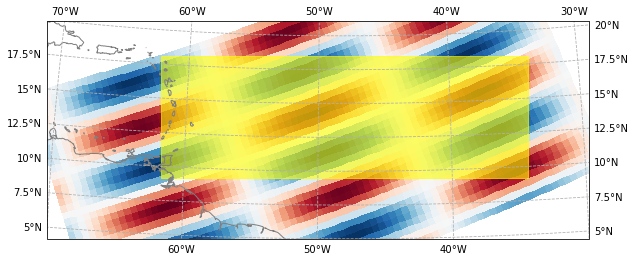

<IPython.core.display.Javascript object>

In [26]:
ax = target_domain.plot_outline(color="yellow")
ax.pcolormesh(ds.lon, ds.lat, ds.phi, transform=ccrs.PlateCarree(), cmap="RdBu_r")
ax.set_extent(extent, crs=ccrs.PlateCarree())

In [20]:
da_phi = ds.phi
da_phi_cropped = rc.crop_field_to_domain(domain=target_domain, da=da_phi, pad_pct=0.0)
da_phi_cropped

/Volumes/agile/tooling/miniconda3/envs/regridcart/lib/python3.7/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


<xarray.DataArray 'phi' (x: 63, y: 37)>
array([[ 0.79379973,  0.98355039,  0.93249361, ..., -0.79379973,
        -0.40969922,  0.07470996],
       [ 0.7983772 ,  0.98922206,  0.93787086, ..., -0.7983772 ,
        -0.41206176,  0.07514078],
       [ 0.79049625,  0.97945724,  0.92861294, ..., -0.79049625,
        -0.40799421,  0.07439905],
       ...,
       [ 0.35619511,  0.44134034,  0.41843006, ..., -0.35619511,
        -0.1838409 ,  0.03352397],
       [ 0.26431872,  0.32750173,  0.31050089, ..., -0.26431872,
        -0.13642128,  0.02487686],
       [ 0.16831773,  0.20855256,  0.19772645, ..., -0.16831773,
        -0.08687285,  0.01584154]])
Coordinates:
  * x        (x) float64 -13.0 -12.5 -12.0 -11.5 -11.0 ... 16.5 17.0 17.5 18.0
  * y        (y) float64 -8.5 -8.0 -7.5 -7.0 -6.5 -6.0 ... 7.5 8.0 8.5 9.0 9.5
    lon      (x, y) float64 -59.31 -59.48 -59.65 -59.82 ... -35.99 -36.16 -36.33
    lat      (x, y) float64 0.068 0.5379 1.008 1.478 ... 26.17 26.64 27.11 27.58

<IPython.core.display.Javascript object>

/Volumes/agile/tooling/miniconda3/envs/regridcart/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


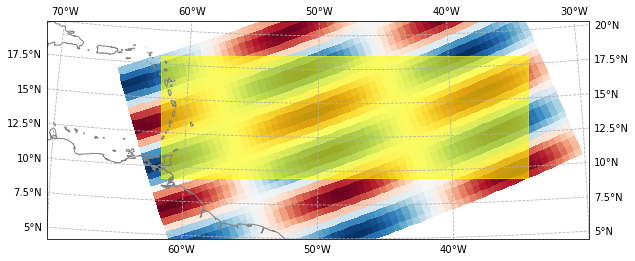

<IPython.core.display.Javascript object>

In [25]:
ax = target_domain.plot_outline(color="yellow")
ax.pcolormesh(
    da_phi_cropped.lon,
    da_phi_cropped.lat,
    da_phi_cropped,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
)
ax.set_extent(extent, crs=ccrs.PlateCarree())

In [23]:
dx = 50.0e3  # [m]
da_phi_resampled = rc.resample(target_domain, da=da_phi_cropped, dx=dx)
da_phi_resampled

/Volumes/agile/tooling/miniconda3/envs/regridcart/lib/python3.7/site-packages/xesmf/smm.py:129: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


<xarray.DataArray (y: 20, x: 60)>
array([[-0.79890737, -0.6852071 , -0.56902025, ...,  0.97574469,
         0.96080419,  0.87717384],
       [-0.93909568, -0.8711384 , -0.79570447, ...,  0.91484402,
         0.93902339,  0.93616803],
       [-0.91114856, -0.90188864, -0.88032609, ...,  0.68066351,
         0.76750111,  0.84218366],
       ...,
       [-0.65772527, -0.62095959, -0.56790279, ...,  0.53189445,
         0.55269662,  0.51194851],
       [-0.46319139, -0.47694701, -0.45228627, ...,  0.29149164,
         0.34869097,  0.36904645],
       [-0.19571429, -0.25342103, -0.27047331, ...,  0.01716612,
         0.11829757,  0.1865359 ]])
Coordinates:
    lon      (y, x) float64 -61.45 -60.99 -60.54 -60.08 ... -35.0 -34.52 -34.05
    lat      (y, x) float64 9.358 9.381 9.403 9.425 ... 17.96 17.93 17.9 17.87
  * x        (x) float64 -1.475e+06 -1.425e+06 ... 1.425e+06 1.475e+06
  * y        (y) float64 -4.75e+05 -4.25e+05 -3.75e+05 ... 4.25e+05 4.75e+05
Attributes:
    regrid_method:  bilinear

<IPython.core.display.Javascript object>

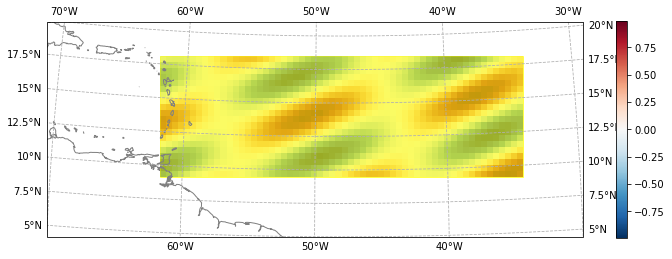

<IPython.core.display.Javascript object>

In [24]:
ax = target_domain.plot_outline(color="yellow")
da_phi_resampled.plot(ax=ax, transform=target_domain.crs)
ax.set_extent(extent, crs=ccrs.PlateCarree())